# Imports
---
---

In [2]:
import hapi
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import voigt_profile
from scipy.optimize import curve_fit
from scipy.constants import k as k_B, c, N_A
from typing import List, Dict, Any, Tuple

HAPI version: 1.2.2.4
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

---
---
# Simulating and Fitting Cantilever-Enhanced Photoacoustic Spectra (2f WMS)

This notebook demonstrates a two-part approach to analyzing 2nd harmonic (2f) data from Wavelength Modulation Spectroscopy (WMS), commonly used in Cantilever-Enhanced Photoacoustic Spectroscopy (CEPAS).

1.  **Forward Model:** We will simulate the expected 2f signal based on fundamental physical parameters like temperature and pressure.
2.  **Inverse Problem:** We will fit this model to experimental data to extract those physical parameters.

The core of the model is the **Voigt profile**, which accurately describes the absorption lineshape, and the approximation that the 2f signal is proportional to the **second derivative** of this lineshape.


---

# Advanced Introduction: The Physics of Photoacoustic Line Fitting



### Objective
This notebook provides a comprehensive framework for analyzing 2nd harmonic wavelength modulation spectroscopy (2f-WMS) data. The core goal is to construct a "forward model" based on fundamental physics that can accurately simulate a measured spectral line. We then use this model to fit experimental data, allowing us to solve the "inverse problem" of deducing physical parameters like gas pressure from the spectral lineshape.

### Part 1: The Absorption Lineshape - A Voigt Profile

The interaction of light with a molecule at a specific transition is not infinitely sharp. The absorption probability as a function of wavenumber, $\tilde{\nu}$, is described by a lineshape function. In the conditions present in most gas-phase spectroscopy, this shape is a **Voigt profile**, $V(\tilde{\nu})$.

The Voigt profile arises because the overall lineshape is a convolution of two independent broadening mechanisms:

1.  **Gaussian Broadening (Doppler Effect):** Caused by the thermal motion of molecules.
2.  **Lorentzian Broadening (Collisional/Pressure Effect):** Caused by collisions between molecules.

Mathematically, the Voigt profile is the convolution of a Gaussian profile $G$ and a Lorentzian profile $L$:

$$
V(\tilde{\nu}) = (G * L)(\tilde{\nu}) = \int_{-\infty}^{\infty} G(\tilde{\nu}'; \Delta\tilde{\nu}_G) L(\tilde{\nu} - \tilde{\nu}'; \Delta\tilde{\nu}_L) \, d\tilde{\nu}'
$$

where $\Delta\tilde{\nu}_G$ and $\Delta\tilde{\nu}_L$ represent the characteristic widths of the Gaussian and Lorentzian profiles, respectively.

### Part 2: Calculating the Broadening Widths from Physical Parameters

The power of this model comes from the fact that the broadening widths are directly determined by the physical state of the gas.

#### Gaussian (Doppler) Broadening
Thermal motion causes molecules to have a velocity distribution relative to the laser beam. This leads to a distribution of Doppler shifts, resulting in a Gaussian lineshape. The Half-Width at Half-Maximum (HWHM), denoted $\Delta\tilde{\nu}_G$, is given by:

$$
\Delta\tilde{\nu}_G = \tilde{\nu}_0 \sqrt{\frac{2 k_B T \ln(2)}{m c^2}}
$$

where:
- $\tilde{\nu}_0$ is the center wavenumber of the transition (cm⁻¹).
- $k_B$ is the Boltzmann constant ($1.3806 \times 10^{-23}$ J/K).
- $T$ is the absolute temperature (K).
- $m$ is the mass of a single molecule (kg). In our code, we use molar mass $M$ (kg/mol) and Avogadro's number $N_A$, so $m = M/N_A$.
- $c$ is the speed of light ($3 \times 10^8$ m/s).

The `scipy.special.voigt_profile` function uses the Gaussian standard deviation, $\sigma_G$, which is related to the HWHM by:

$$
\sigma_G = \frac{\Delta\tilde{\nu}_G}{\sqrt{2 \ln(2)}}
$$

#### Lorentzian (Collisional) Broadening
Collisions between molecules interrupt the absorption process, which, through the Heisenberg uncertainty principle, broadens the energy levels of the transition. This results in a Lorentzian lineshape. The Lorentzian HWHM, $\Delta\tilde{\nu}_L$, is directly proportional to the number of collisions per second, and thus to the gas pressure $P$.

The relationship also depends on temperature, as higher temperatures lead to faster, more frequent collisions. This is captured by the temperature-dependent pressure-broadening coefficient, $\gamma_L(T)$:

$$
\Delta\tilde{\nu}_L(P, T) = P \cdot \gamma_L(T)
$$

The coefficient $\gamma_L(T)$ is typically referenced to a standard temperature $T_0$ (e.g., 296 K) and scaled using an empirical temperature exponent, $n$:

$$
\gamma_L(T) = \gamma_{L0} \left(\frac{T_0}{T}\right)^n
$$

Combining these gives the full expression for the Lorentzian HWHM implemented in our code:

$$
\Delta\tilde{\nu}_L = P \cdot \gamma_{L0} \left(\frac{T_0}{T}\right)^n
$$

where:
- $P$ is the pressure (atm).
- $\gamma_{L0}$ is the reference pressure-broadening coefficient (cm⁻¹/atm at $T_0$).
- $T_0$ is the reference temperature (K).
- $T$ is the gas temperature (K).
- $n$ is the temperature-dependence exponent.

### Part 3: The 2f Wavelength Modulation Spectroscopy (WMS) Signal

In 2f-WMS, the laser's wavenumber is modulated sinusoidally around a central wavenumber, $\tilde{\nu}_{center}$:
$ \tilde{\nu}(t) = \tilde{\nu}_{center} + a \cos(\omega t) $.
The resulting absorption signal is detected using a lock-in amplifier referenced to the *second harmonic* of the modulation frequency, $2\omega$.

A key result from the theory of WMS is that for small modulation amplitudes ($a \ll \Delta\tilde{\nu}_V$, where $\Delta\tilde{\nu}_V$ is the Voigt width), the 2f signal, $S_{2f}$, is well-approximated by the second derivative of the absorption lineshape. To account for signal strength and any DC offsets, we model the signal as:

$$
S_{2f}(\tilde{\nu}) \approx A \cdot \left(-\frac{d^2}{d\tilde{\nu}^2} V(\tilde{\nu}; \sigma_G, \Delta\tilde{\nu}_L)\right) + B
$$

where:
- $A$ is an overall amplitude parameter, which depends on laser power, detector sensitivity, and species concentration.
- $B$ is a constant baseline offset.
- $V(\tilde{\nu}; \sigma_G, \Delta\tilde{\nu}_L)$ is the Voigt profile centered at $\tilde{\nu}_0$, whose shape is determined by $\sigma_G(T)$ and $\Delta\tilde{\nu}_L(P, T)$.

### Summary: The Model for Fitting
By combining these equations, we construct a complete forward model, $S_{2f}(\tilde{\nu})$, that depends on a set of parameters: $\{\tilde{\nu}_0, T, P, A, B\}$. In our fitting routine (`curve_fit`), we will provide the experimental data $(\tilde{\nu}_{data}, S_{data})$ and ask the algorithm to find the optimal set of parameters—most importantly, the pressure $P$—that minimizes the difference between our model and the data. Since the temperature $T$ is often measured independently, we treat it as a fixed input to the model during the fit.

---
# Part 0: Getting the correct wavenumber axis from arbitrary `offset1` axis using data from HITRAN

In [3]:
offsets_list_h2o_19_deg = [1503.7818, 976.3011] # add lines from the cepas measurement
wavenumbers_list_h2o = [6984.9535, 6987.1444] # add lines from trusted source, like HITRAN

def get_wavenumber(offset: float, offsets: list[float], wavenumbers: list[float]) -> float:
    lr_wavenumbers = LinearRegression()
    offset_arr = np.array(offsets).reshape(-1, 1)
    wavnumber_arr = np.array(wavenumbers).reshape(-1, 1)
    lr_wavenumbers.fit(offset_arr, wavnumber_arr)
    a = float(lr_wavenumbers.coef_)
    b = float(lr_wavenumbers.intercept_)
    return a*offset + b

print(get_wavenumber(1503.7818, offsets_list_h2o_19_deg, wavenumbers_list_h2o))

6984.9535000000005


/tmp/ipykernel_1376/3707713514.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a = float(lr_wavenumbers.coef_)
/tmp/ipykernel_1376/3707713514.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = float(lr_wavenumbers.intercept_)


---
# Part 1: Simulating the 2f Signal (The Forward Model)

Here, we build a function that takes physical parameters (Temperature, Pressure, etc.) and generates the expected 2f signal.

In [4]:


# --- 1. Setup HAPI Database ---
# This creates a folder named 'data' in your current directory to store the database.
# This only needs to be done once. HAPI will use the local files on subsequent runs.
DB_PATH = 'data'
hapi.db_begin(DB_PATH)

def get_n_strongest(molecule_name: str, molar_mass: float, start: float, end: float, n: int) -> List[Dict[str, Any]]:
    """
    Gets `n` most intensive line parameters for molecule of `molecule_name` from HITRAN database in range
    from `start` to `end`, using `hapi` library

    Args:
        molecule_name (str): name of the molecule, e.g., `'h2o'`
        molar_mass (float): molar mass of the molecule in kg/mol
        start (float): start of the range to work on (in wavenumbers)
        end (float): end of the range to work on (in wavenumbers)
        n (int): amount of lines to return, starting with the most intensive lines
    
    Returns:
        List[Dict[str, Any]]: Returns a list of parameter dicts, w/ names as per `hapi` nomenclature
    """
    line_dicts = []
    
    MOLECULE_NAME = str.upper(molecule_name)
    hapi.fetch(MOLECULE_NAME, 1, 1, start, end)

    line_strengths = hapi.getColumn(MOLECULE_NAME, 'sw') # sw is the line intensity
    line_strengths_df = pd.DataFrame({
        "og_order": list(range(len(line_strengths))),
        "sw": line_strengths
    })
    strongest_line_indexes = line_strengths_df.sort_values(by="sw", ascending=False)[:n]['og_order']

    for strongest_line_index in strongest_line_indexes:
    
        MOL_LINE_PARAMS = {
            'v0': hapi.getColumn(MOLECULE_NAME, 'nu')[strongest_line_index], # Line center in cm^-1
            'gamma_L0': hapi.getColumn(MOLECULE_NAME, 'gamma_air')[strongest_line_index], # Air-broadening coeff at T0, P0
            'n_exp': hapi.getColumn(MOLECULE_NAME, 'n_air')[strongest_line_index], # Temperature exponent
            'T0': 296.0, # Reference Temperature
            'P0': 1.0, # Reference Pressure (atm)
            'M': molar_mass # Molar mass of H2O in kg/mol
        }
        print(f"--- Fetched {molecule_name.upper()} Line Parameters from HITRAN ---")
        for key, val in MOL_LINE_PARAMS.items():
            print(f"{key}: {val}")

        line_dicts.append(MOL_LINE_PARAMS)

    return line_dicts
    

# --- Define Physical Constants and Molecular Properties ---
# Use the ones from specific molecule dict
H2O_LINE_PARAMS = get_n_strongest("h2o", 18.015e-3, 6987.0, 6987.2, 2)
MOLAR_MASS = H2O_LINE_PARAMS[0]['M']  # kg/mol
LINE_CENTER_V0 = H2O_LINE_PARAMS[0]['v0']   # wavenumber cm^-1
PRESSURE_BROAD_COEFF_GAMMA_L0 = H2O_LINE_PARAMS[0]['gamma_L0'] # cm^-1 / atm at T0, P0
TEMP_REF_T0 = 296.0        # Reference temperature for broadening coeff, K
PRESSURE_REF_P0 = 1.0      # Reference pressure for broadening coeff, atm4
TEMP_EXPONENT_N = H2O_LINE_PARAMS[0]['n_exp']     # Temperature dependence exponent for broadening (example)

Using data

H2O
                     Lines parsed: 5

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O
  65536 bytes written to data/H2O.data
Header written to data/H2O.header
END DOWNLOAD
                     Lines parsed: 5
PROCESSED
--- Fetched H2O Line Parameters from HITRAN ---
v0: 6987.144435
gamma_L0: 0.0774
n_exp: 0.62
T0: 296.0
P0: 1.0
M: 0.018015
--- Fetched H2O Line Parameters from HITRAN ---
v0: 6987.085617
gamma_L0: 0.0768
n_exp: 0.61
T0: 296.0
P0: 1.0
M: 0.018015


In [5]:
# --- 2. Functions for Broadening Widths ---

def gaussian_hwhm(v0, T, M):
    """Calculates the Gaussian (Doppler) HWHM in cm^-1."""
    # mass_of_molecule is the mass of a single molecule in kg
    mass_of_molecule = M / N_A
    return v0 * np.sqrt(2 * k_B * T * np.log(2) / (mass_of_molecule * c**2))

def lorentzian_hwhm(P_atm, T, gamma_L0, T0, n):
    """Calculates the Lorentzian (Pressure) HWHM in cm^-1."""
    # Pressure broadening coeff scaled by temperature
    gamma_L = gamma_L0 * (T0 / T)**n
    return P_atm * gamma_L

In [6]:
hwhm_g = gaussian_hwhm(LINE_CENTER_V0, T=296.0, M=MOLAR_MASS)
print(hwhm_g)

0.010142676201689134


In [7]:
# --- 3. The Core Simulation Function ---

def simulate_2f_wms_signal(wavenumber_axis, center_v0, T, P_atm, params, amplitude=1.0, baseline=0.0):
    """
    Simulates a 2f WMS signal based on physical parameters.

    Args:
        wavenumber_axis (np.array): The x-axis for the simulation (in cm^-1).
        center_v0 (float): The center wavenumber of the absorption line (cm^-1).
        T (float): Temperature in Kelvin.
        P_atm (float): Pressure in atmospheres.
        amplitude (float): Overall signal amplitude scaling factor.
        baseline (float): A constant baseline offset.

    Returns:
        np.array: The simulated 2f WMS signal.
    """
    # Calculate broadening widths for the Voigt profile
    # scipy.special.voigt_profile uses sigma (Gaussian std dev) and gamma (Lorentzian HWHM)
    
    # Gaussian HWHM -> sigma
    TEMP_REF_T0 = 296.0 # in Kelvin
    hwhm_g = gaussian_hwhm(center_v0, T, params['M'])
    sigma_g = hwhm_g / np.sqrt(2 * np.log(2))
    
    # Lorentzian HWHM
    gamma_l = lorentzian_hwhm(P_atm, T, params['gamma_L0'], TEMP_REF_T0, params['n_exp'])

    # Generate the Voigt profile (absorption line)
    # The x-axis for voigt_profile is relative to the center
    relative_wavenumber = wavenumber_axis - center_v0
    absorption_profile = voigt_profile(relative_wavenumber, sigma_g, gamma_l)

    # Calculate the 2nd derivative to approximate the 2f signal
    # We use np.gradient twice for a numerical derivative
    grad1 = np.gradient(absorption_profile, wavenumber_axis)
    grad2 = np.gradient(grad1, wavenumber_axis)

    # The 2f signal is proportional to the *negative* 2nd derivative
    signal_2f = -grad2

    # Scale by amplitude, normalize, and add baseline
    # Normalizing makes the amplitude parameter more intuitive
    if np.max(np.abs(signal_2f)) > 0:
        signal_2f = signal_2f / np.max(np.abs(signal_2f))

    return amplitude * signal_2f + baseline

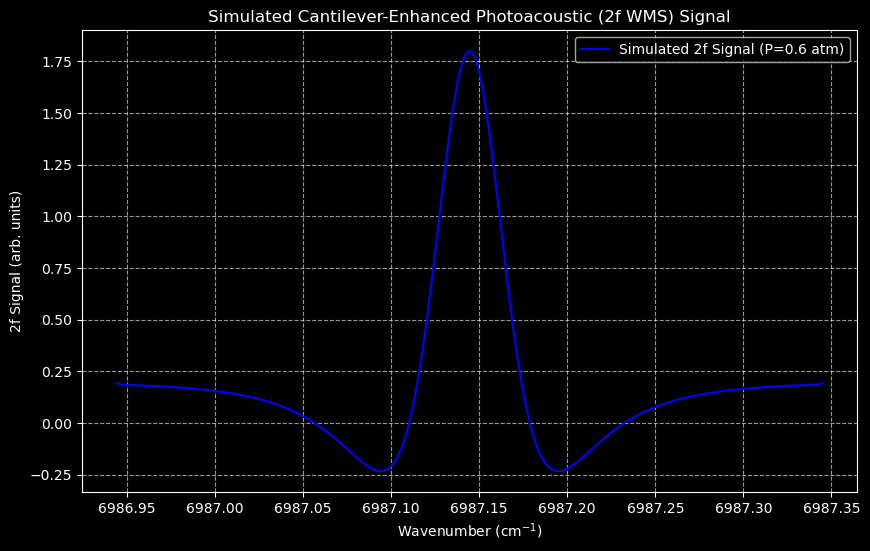

In [8]:
# --- 4. Example Usage: Generate and Plot a Simulated Signal ---

# Define simulation parameters
wavenumber_range = np.linspace(LINE_CENTER_V0 - 0.2, LINE_CENTER_V0 + 0.2, 500)
temperature_K = 292.15
pressure_atm = 0.6  # Simulate at half an atmosphere

# Generate the signal
simulated_signals = []
for i in range(2):
    signal = simulate_2f_wms_signal(
        wavenumber_axis=wavenumber_range,
        center_v0=LINE_CENTER_V0,
        T=temperature_K,
        P_atm=pressure_atm,
        params=H2O_LINE_PARAMS[i],
        amplitude=0.8,
        baseline=0.1
    )
    simulated_signals.append(signal)
    
# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wavenumber_range, simulated_signals[0]+simulated_signals[1], 'b-', label=f'Simulated 2f Signal (P={pressure_atm} atm)')
ax.set_title('Simulated Cantilever-Enhanced Photoacoustic (2f WMS) Signal')
ax.set_xlabel('Wavenumber (cm$^{-1}$)')
ax.set_ylabel('2f Signal (arb. units)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

---
# Part 2: Fitting Experimental Data (The Inverse Problem)

Now, we'll use our simulation function as a model to fit "experimental" data. We will generate some synthetic data for this demonstration. In a real-world scenario, you would load your own data here.

The goal is to use the known lineshape to deduce an unknown physical parameter, such as pressure. We'll use `scipy.optimize.curve_fit` for this task.

--- Generating synthetic experimental data ---


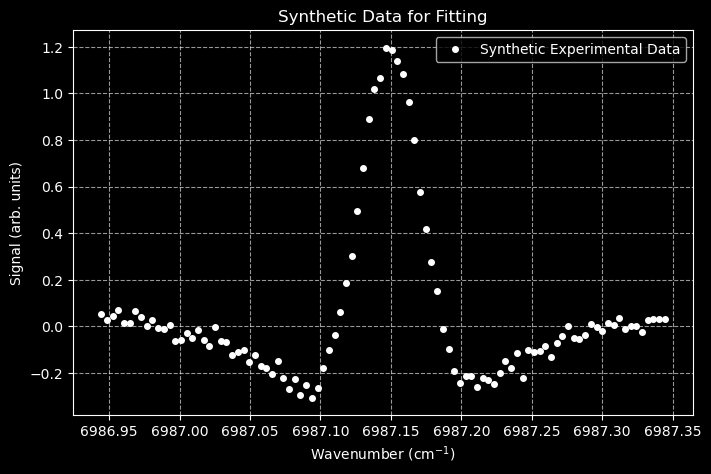

In [9]:
# --- 5. Generate "Experimental" Data ---
# In a real scenario, you would load this from a file (e.g., using pandas.read_csv)

print("--- Generating synthetic experimental data ---")

# Let's create some fake data with known parameters
true_pressure = 0.75 # atm
true_amplitude = 1.15
true_center = LINE_CENTER_V0 + 0.005 # Slight shift from the database value
true_baseline = 0.05
fixed_temperature = 298.0 # We assume T is known from a sensor

experimental_wavenumbers = np.linspace(LINE_CENTER_V0 - 0.2, LINE_CENTER_V0 + 0.2, 100)
perfect_signal = simulate_2f_wms_signal(
    wavenumber_axis=experimental_wavenumbers,
    center_v0=true_center,
    T=fixed_temperature,
    P_atm=true_pressure,
    params=H2O_LINE_PARAMS[0],
    amplitude=true_amplitude,
    baseline=true_baseline
)

# Add some realistic noise
np.random.seed(42) # for reproducibility
noise = np.random.normal(0, 0.03, size=experimental_wavenumbers.shape)
experimental_signal = perfect_signal + noise

# Let's plot our synthetic data to see what it looks like
plt.figure(figsize=(8, 5))
plt.plot(experimental_wavenumbers, experimental_signal, 'wo', label='Synthetic Experimental Data', markersize=4)
plt.title("Synthetic Data for Fitting")
plt.xlabel("Wavenumber (cm$^{-1}$)")
plt.ylabel("Signal (arb. units)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [10]:
# --- 6. Define the Model Function for Fitting ---
# `curve_fit` requires the function signature to be `f(x, param1, param2, ...)`

def model_for_fitting(wavenumber_axis, P_atm, amplitude, center_v0, baseline):
    """
    A wrapper for the simulation function in the format required by curve_fit.
    
    Temperature is fixed (assumed to be known) because fitting for both T and P
    simultaneously can be unstable as both affect the line width.
    """
    return simulate_2f_wms_signal(
        wavenumber_axis,
        center_v0=center_v0,
        T=fixed_temperature, # Using the global `fixed_temperature`
        P_atm=P_atm,
        params=H2O_LINE_PARAMS[0],
        amplitude=amplitude,
        baseline=baseline
    )


--- Fit Results ---
True Pressure: 0.7500 atm
Fitted Pressure: 0.7489 ± 0.0058 atm

--- All Fitted Parameters ---
Amplitude: 1.152 (True: 1.15)
Center Wavenumber: 6987.1496 cm^-1 (True: 6987.1494)
Baseline: 0.047 (True: 0.05)


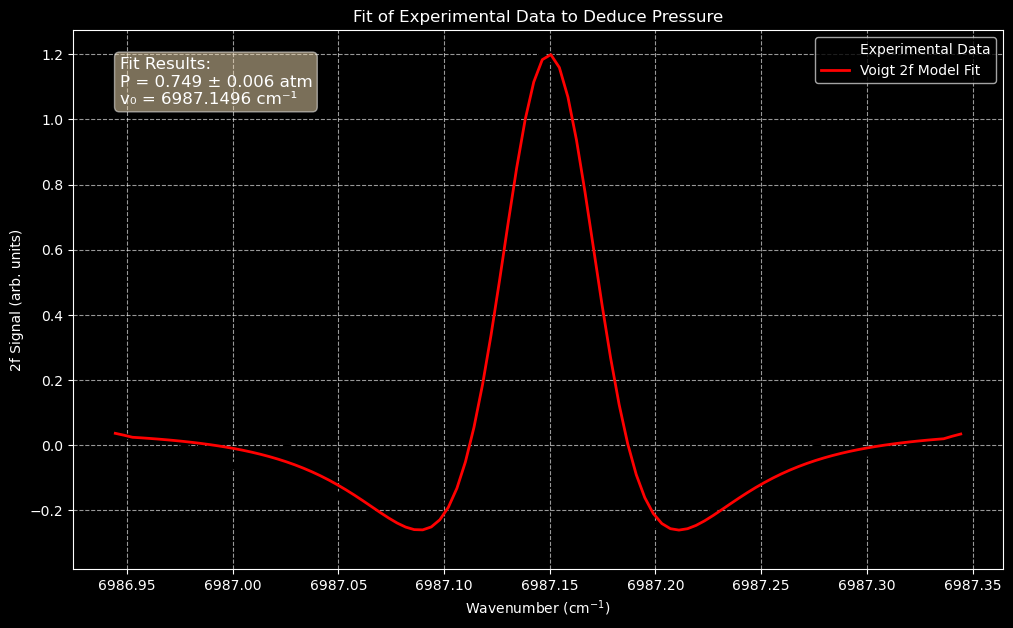

In [11]:
# --- 7. Perform the Fit ---

# Provide initial guesses for the parameters [P_atm, amplitude, center_v0, baseline]
initial_guesses = [
    0.5,             # P_atm (atm)
    1.0,             # amplitude
    LINE_CENTER_V0,  # center_v0 (cm^-1)
    0.0              # baseline
]

# Provide bounds to constrain the fit (highly recommended!)
# Format: ([lower bounds], [upper bounds])
bounds = (
    [0.01, 0.1, LINE_CENTER_V0 - 0.1, -0.5], # Lower bounds
    [2.0,  5.0, LINE_CENTER_V0 + 0.1, 0.5]     # Upper bounds
)

try:
    popt, pcov = curve_fit(
        f=model_for_fitting,
        xdata=experimental_wavenumbers,
        ydata=experimental_signal,
        p0=initial_guesses,
        bounds=bounds
    )

    # --- 8. Analyze and Display Results ---
    fitted_pressure, fitted_amplitude, fitted_center, fitted_baseline = popt
    
    # Get the standard deviation errors on the parameters from the covariance matrix
    perr = np.sqrt(np.diag(pcov))
    pressure_error = perr[0]

    print("\n--- Fit Results ---")
    print(f"True Pressure: {true_pressure:.4f} atm")
    print(f"Fitted Pressure: {fitted_pressure:.4f} ± {pressure_error:.4f} atm")
    print("\n--- All Fitted Parameters ---")
    print(f"Amplitude: {fitted_amplitude:.3f} (True: {true_amplitude})")
    print(f"Center Wavenumber: {fitted_center:.4f} cm^-1 (True: {true_center:.4f})")
    print(f"Baseline: {fitted_baseline:.3f} (True: {true_baseline})")

    # Generate the fitted curve for plotting
    fit_curve = model_for_fitting(experimental_wavenumbers, *popt)

    # Plot the final result
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(experimental_wavenumbers, experimental_signal, 'ko', label='Experimental Data', markersize=5)
    ax.plot(experimental_wavenumbers, fit_curve, 'r-', linewidth=2, label='Voigt 2f Model Fit')
    ax.set_title('Fit of Experimental Data to Deduce Pressure')
    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax.set_ylabel('2f Signal (arb. units)')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add a text box to display the main result on the plot
    result_text = (f"Fit Results:\n"
                   f"P = {fitted_pressure:.3f} ± {pressure_error:.3f} atm\n"
                   f"v₀ = {fitted_center:.4f} cm⁻¹")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, result_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
            
    plt.show()

except RuntimeError as e:
    print(f"Error: The fit did not converge. Try adjusting initial guesses or bounds. \n{e}")

---
## How to Adapt for Your Real Data

1.  **Load Your Data:** Replace the "Generate Experimental Data" section with code to load your data. If your data is in a CSV file with columns `wavenumber` and `signal`, you can use `pandas`:
    ```python
    import pandas as pd
    df = pd.read_csv('your_data_file.csv')
    experimental_wavenumbers = df['wavenumber'].values
    experimental_signal = df['signal'].values
    ```

2.  **Use a Real Spectroscopic Database (HITRAN):** The parameters like `LINE_CENTER_V0`, `PRESSURE_BROAD_COEFF_GAMMA_L0`, `MOLAR_MASS`, etc., should not be hardcoded for high-accuracy work. You should use a library like **HAPI** (`pip install hapi`) to fetch these parameters from the HITRAN database for your specific molecule and transition line. This will make your model much more accurate.

3.  **Baseline Correction:** Real data often has a non-flat baseline due to etalon effects or other optical issues. You might need to:
    *   Fit and subtract a polynomial baseline from your data *before* fitting the line.
    *   Incorporate a polynomial baseline into your `model_for_fitting` function itself. For example: `model_for_fitting(x, P, amp, v0, bl, c1, c2)` where the final signal is `simulate_2f(...) + c1*x + c2`. Be aware that adding more free parameters makes the fit more challenging.

4.  **Fitting Multiple Parameters:** Be cautious. If you try to fit for Temperature *and* Pressure simultaneously, the fit might become unstable because both affect the line width. Usually, you would measure the temperature independently (e.g., with a thermocouple in your gas cell) and keep it as a fixed parameter in the model, as we did in this example.

# Bonus: Using HAPI for Accurate, Database-Driven Analysis

In the previous examples, we used hard-coded "example" values for the physical constants of the absorption line (line center, broadening coefficient, etc.). For real scientific work, this is not a robust approach. The **HITRAN database** is the international standard for spectroscopic parameters, and the **HAPI** (HITRAN Application Programming Interface) library for Python provides a programmatic way to access it.

This makes our analysis far more accurate and reproducible. Instead of guessing parameters, we query a database for them.

### Workflow with HAPI
1.  **Installation:** First, install the HAPI library.
    ```bash
    pip install hapi
    ```
2.  **Database Setup:** Create a local database file where HAPI will store the data it downloads. This is a one-time setup.
3.  **Fetch Data:** Query the database for a specific molecule (e.g., H₂O) in a desired wavenumber range.
4.  **Extract Parameters:** Pull the relevant parameters (line center `nu`, air-broadening `gamma_air`, temperature exponent `n_air`, etc.) for the line(s) of interest.
5.  **Simulate & Fit:** Use these high-fidelity parameters in our existing simulation and fitting functions.

---
### Example: Simulating and Fitting a Water Vapor Line

Let's apply this process to a real water vapor (H₂O) line around 7181.5 cm⁻¹.

Using data

H2O
                     Lines parsed: 5

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: H2O
  65536 bytes written to data/H2O.data
Header written to data/H2O.header
END DOWNLOAD
                     Lines parsed: 5
PROCESSED
--- Fetched H2O Line Parameters from HITRAN ---
v0: 6987.144435
gamma_L0: 0.0774
n_exp: 0.62
T0: 296.0
P0: 1.0
M: 0.018015

--- Fitting Results ---
True Pressure: 0.6000 atm
Fitted Pressure: 0.5993 ± 0.0054 atm


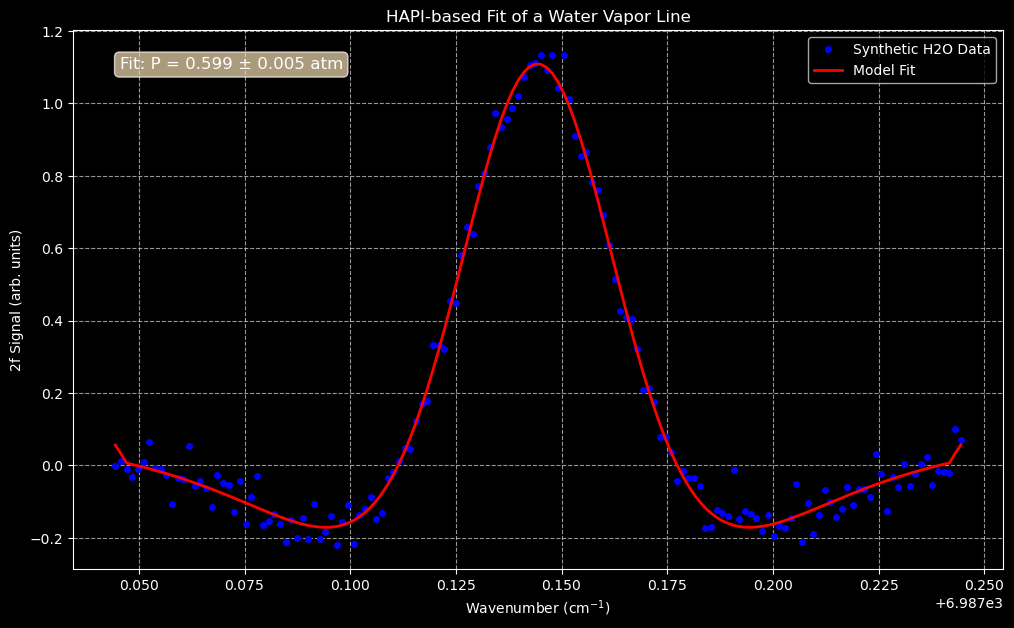

In [12]:
# --- 1. Setup HAPI Database ---
# This creates a folder named 'data' in your current directory to store the database.
# This only needs to be done once. HAPI will use the local files on subsequent runs.
DB_PATH = 'data'
hapi.db_begin(DB_PATH)

# --- 2. Fetch Water Vapor Data ---
# We will fetch data for H2O (Molecule ID=1, Isotope=1) in a narrow range.
MOLECULE_NAME = 'H2O'
hapi.fetch(MOLECULE_NAME, 1, 1, 6987, 6987.2)

# --- 3. Extract Line Parameters from the Database ---
# A query can return multiple lines. For this example, we'll pick the strongest one.
line_strengths = hapi.getColumn(MOLECULE_NAME, 'sw') # sw is the line intensity
strongest_line_index = np.argmax(line_strengths)

# Pack the parameters into a dictionary for easy use
H2O_LINE_PARAMS = {
    'v0': hapi.getColumn(MOLECULE_NAME, 'nu')[strongest_line_index], # Line center in cm^-1
    'gamma_L0': hapi.getColumn(MOLECULE_NAME, 'gamma_air')[strongest_line_index], # Air-broadening coeff at T0, P0
    'n_exp': hapi.getColumn(MOLECULE_NAME, 'n_air')[strongest_line_index], # Temperature exponent
    'T0': 296.0, # Reference Temperature
    'P0': 1.0, # Reference Pressure (atm)
    'M': 18.015e-3 # Molar mass of H2O in kg/mol
}

print("--- Fetched H2O Line Parameters from HITRAN ---")
for key, val in H2O_LINE_PARAMS.items():
    print(f"{key}: {val}")

# --- 4. Use HAPI Parameters in our Model ---
# We re-use the functions from before, but now we pass the HAPI parameters.

def simulate_2f_hapi(wavenumber_axis, line_params, T, P_atm, amplitude, baseline):
    """Simulation function that uses a line parameter dictionary."""
    hwhm_g = line_params['v0'] * np.sqrt(2*k_B*T*np.log(2) / ((line_params['M']/N_A) * c**2))
    sigma_g = hwhm_g / np.sqrt(2 * np.log(2))
    
    gamma_l_scaled = line_params['gamma_L0'] * (line_params['T0'] / T)**line_params['n_exp']
    gamma_l = P_atm * gamma_l_scaled
    
    relative_wavenumber = wavenumber_axis - line_params['v0']
    absorption_profile = voigt_profile(relative_wavenumber, sigma_g, gamma_l)
    
    grad2 = np.gradient(np.gradient(absorption_profile, wavenumber_axis), wavenumber_axis)
    signal_2f = -grad2
    
    if np.max(np.abs(signal_2f)) > 0:
        signal_2f = signal_2f / np.max(np.abs(signal_2f))
        
    return amplitude * signal_2f + baseline

# --- 5. Create Synthetic Data and Fit ---

# Known conditions for our synthetic data
TEMPERATURE = 298.0 # K
TRUE_PRESSURE = 0.6 # atm
TRUE_AMPLITUDE = 1.0
TRUE_BASELINE = 0.1

# Generate the data
wavenumbers = np.linspace(H2O_LINE_PARAMS['v0'] - 0.1, H2O_LINE_PARAMS['v0'] + 0.1, 150)
perfect_signal = simulate_2f_hapi(wavenumbers, H2O_LINE_PARAMS, TEMPERATURE, TRUE_PRESSURE, TRUE_AMPLITUDE, TRUE_BASELINE)
noise = np.random.normal(0, 0.04, perfect_signal.shape)
experimental_data = perfect_signal + noise

# Define the fitting function for curve_fit
def model_for_fitting_h2o(wavenumber_axis, P_atm, amplitude, baseline, v0_offset):
    """
    Fitting model for H2O. We fit for pressure and an amplitude/baseline.
    We also fit for a small *offset* to the line center, which is more stable
    than fitting the absolute value.
    """
    # Create a temporary copy of the params and apply the offset
    params = H2O_LINE_PARAMS.copy()
    params['v0'] += v0_offset
    return simulate_2f_hapi(wavenumber_axis, params, TEMPERATURE, P_atm, amplitude, baseline)

# Perform the fit
initial_guesses = [0.5, 0.9, 0.05, 0.0]  # P_atm, amplitude, baseline, v0_offset
bounds = ([0.01, 0.1, -0.2, -0.01], [1.5, 2.0, 0.2, 0.01]) # Lower and Upper bounds

try:
    popt, pcov = curve_fit(model_for_fitting_h2o, wavenumbers, experimental_data, p0=initial_guesses, bounds=bounds)
    
    fitted_pressure = popt[0]
    perr = np.sqrt(np.diag(pcov))
    pressure_error = perr[0]

    print("\n--- Fitting Results ---")
    print(f"True Pressure: {TRUE_PRESSURE:.4f} atm")
    print(f"Fitted Pressure: {fitted_pressure:.4f} ± {pressure_error:.4f} atm")

    # Plotting
    fit_curve = model_for_fitting_h2o(wavenumbers, *popt)
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(wavenumbers, experimental_data, 'bo', label='Synthetic H2O Data', markersize=4)
    ax.plot(wavenumbers, fit_curve, 'r-', linewidth=2, label='Model Fit')
    ax.set_title('HAPI-based Fit of a Water Vapor Line')
    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax.set_ylabel('2f Signal (arb. units)')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    result_text = f"Fit: P = {fitted_pressure:.3f} ± {pressure_error:.3f} atm"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.05, 0.95, result_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
    plt.show()
except RuntimeError as e:
    print(f"Fit failed: {e}")

In [13]:
print(type(experimental_data))

<class 'numpy.ndarray'>


# Doppler vs Pressure (Lorentz)

Molecule: CO2
Temperature: 296.0 K
Transition Wavenumber (v0): 6983.6678 cm^-1
Air-Broadening Coefficient (γ_air): 0.0905 cm^-1/atm
------------------------------
Constant Doppler Width (HWHM): 0.010128 cm^-1
Crossover Pressure: 0.1119 atm


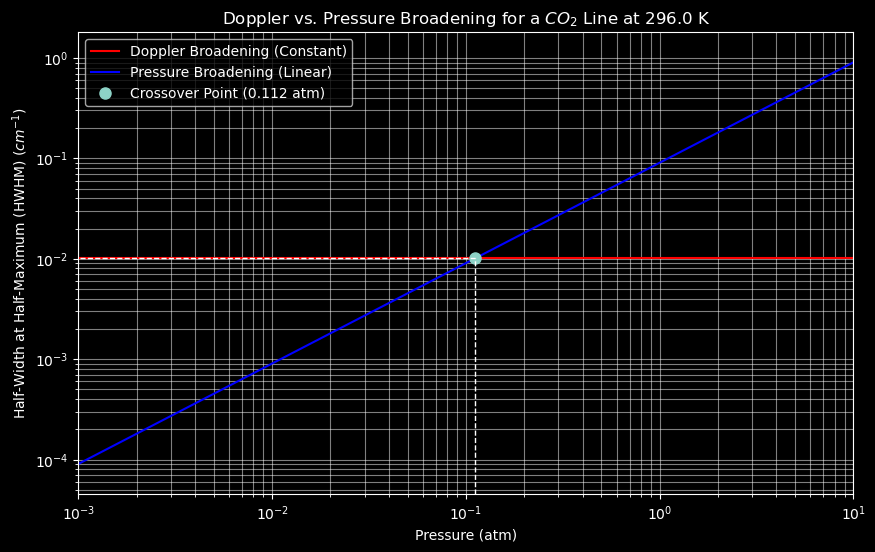

In [14]:
# --- 1. Constants and Parameters ---


# Example: CO2 molecule, a line from the R-branch of the nu3 band
# --- These values would be taken from the HITRAN database ---
nu_0_cm = 6983.6678   # Wavenumber (cm^-1)
gamma_air = 0.0905      # Air-broadened half-width (cm^-1 / atm) at 296K
M = 18.05e-3            # Molar mass of CO2 (kg/mol)
T = 296.0               # Temperature (K)

# --- 2. Calculate Broadening Widths ---

# Calculate the mass of a single molecule
m_molecule = M / N_A  # kg

# Calculate Doppler Broadening (HWHM)
# Note: Convert nu_0 to m^-1 for calculation, then convert result back to cm^-1
nu_0_m = nu_0_cm * 100
doppler_width_m = nu_0_m * np.sqrt((2 * k_B * T * np.log(2)) / (m_molecule * c**2))
doppler_width_cm = doppler_width_m / 100

print("Molecule: CO2")
print(f"Temperature: {T} K")
print(f"Transition Wavenumber (v0): {nu_0_cm:.4f} cm^-1")
print(f"Air-Broadening Coefficient (γ_air): {gamma_air:.4f} cm^-1/atm")
print("-" * 30)
print(f"Constant Doppler Width (HWHM): {doppler_width_cm:.6f} cm^-1")

# Create a pressure range for plotting (log scale is best)
pressures = np.logspace(-3, 1, 500)  # 0.001 to 10 atm

# Calculate Pressure Broadening (HWHM) across the pressure range
pressure_width_cm = gamma_air * pressures

# --- 3. Find the Crossover Pressure ---
crossover_pressure = doppler_width_cm / gamma_air
print(f"Crossover Pressure: {crossover_pressure:.4f} atm")

# --- 4. Plot the Results ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Doppler (constant) and Pressure (linear) broadening
ax.plot(pressures, np.full_like(pressures, doppler_width_cm), 'r', label='Doppler Broadening (Constant)')
ax.plot(pressures, pressure_width_cm, 'b', label='Pressure Broadening (Linear)')

# Mark the crossover point
crossover_width = gamma_air * crossover_pressure
ax.plot(crossover_pressure, crossover_width, 'o', markersize=8, label=f'Crossover Point ({crossover_pressure:.3f} atm)')
ax.vlines(crossover_pressure, 0, crossover_width, colors='white', linestyles='--', lw=1)
ax.hlines(crossover_width, 0, crossover_pressure, colors='white', linestyles='--', lw=1)

# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Pressure (atm)')
ax.set_ylabel('Half-Width at Half-Maximum (HWHM) ($cm^{-1}$)')
ax.set_title(f'Doppler vs. Pressure Broadening for a $CO_2$ Line at {T} K')
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.5)

# Limit the view for clarity
ax.set_xlim(pressures.min(), pressures.max())
min_y = min(doppler_width_cm, pressure_width_cm.min()) * 0.5
max_y = max(doppler_width_cm, pressure_width_cm.max()) * 2
ax.set_ylim(min_y, max_y)

plt.show()